## LDA (Linear Discriminant Analysis). Сравнение LDA и PCA. Тематическое моделирование.

In [1]:
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import  CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA,LatentDirichletAllocation
import matplotlib.pyplot as plt

#### Главное отличие LDA от PCA: LDA - это алгоритм обучения с учителем, а PCA - нет.

PCA находит направления с максимальной дисперсией и проектирует данные на эти направления.
LDA создает новую ось таким образом, что при проецировании данных на эту ось объекты двух классов максимально разделяются.

In [2]:
Iris = load_iris()

data = Iris.data
target = Iris.target
target_names = Iris.target_names

In [3]:
df = pd.DataFrame(data=np.concatenate((data,target.reshape(150,1)),axis=1),\
                  columns=['col_1','col_2','col_3','col_4','target'])
df.head()

,col_1,col_2,col_3,col_4,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [4]:
df.drop(columns=['target'], axis=1, inplace=True)

In [5]:
pca = PCA(n_components=2)
X_feature_reduced = pca.fit(df).transform(df)

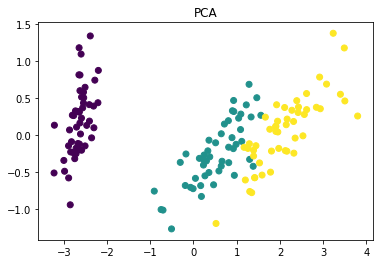

In [6]:
plt.scatter(X_feature_reduced[:,0], X_feature_reduced[:,1], c=target)
plt.title("PCA")
plt.show()

In [7]:
lda = LatentDirichletAllocation(n_components=2)

X_feature_reduced2 = lda.fit(df, target).transform(df)

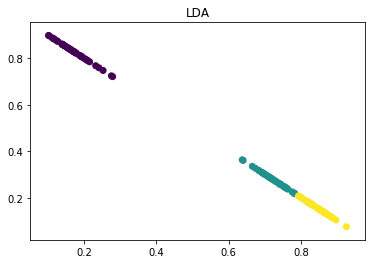

In [8]:
plt.scatter(X_feature_reduced2[:,0], X_feature_reduced2[:,1], c=target)
plt.title('LDA')
plt.show()

**Наблюдение**

Мы видим, что LDA проектирует данные на такую новую ось, что классы максимально разделены.

### Тематическое моделирование (topic modelling)

Тематическое моделирование - это присваивание темы (topic) каждому документу. Каждая тема представлена определенными словами.

Рассмотрим пример:

У нас есть два топика: топик 1 и топик 2. Топик1 представлен словами "apple, banana, mange",
топик2 - словами "tennis, cricket, hockey". Можем предположить, что в топике1 речь идет о фруктах, а в топике2 - о спорте. Затем каждому новому документу мы присваиваем одну из этих тем (топик1 или топик2).

Другой пример: предположим, у нас есть 6 документов

apple banana
apple orange
banana orange
tiger cat
tiger dog
cat dog

Что будет происходить с тематическим моделированием, если мы захотим извлечь две темы (два топика) из этих документов?
Мы получим два распределения: распределение тема-слово (topic-word) и распределение документ-тема (doc-topic).

Идеальное распределение документ-слово в данном примере будет таким:

![How](df1.png)

Идеальное распределение документ-тема будет таким:

![How](df2.png)

Предположим, что у нас есть новый документ "cat dog apple", тогда его представление по темам должно быть следующим:

Topic1: 0.33

Topic2: 0.63

LDA широко применяется в таких задачах. Его использование для тематического моделирования продемонстрировано ниже. 

Мы подаем на вход LDA число тем (topics), которые хотим выделить в корпусе. 

Но сначала необходимо векторизовать слова (будем использовать подход - мешок слов), поэтому взаимосвязь между словами в текстах при таком подходе исчезнет.

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elena\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
lemmatizer = WordNetLemmatizer() #For words Lemmatization
stemmer = PorterStemmer()  #For stemming words
stop_words = set(stopwords.words('english'))

In [11]:
def TokenizeText(text):
    ''' 
     Tokenizes text by removing various stopwords and lemmatizing them
    '''
    text=re.sub('[^A-Za-z0-9\s]+', '', text)
    word_list=word_tokenize(text)
    word_list_final=[]
    
    for word in word_list:
        if word not in stop_words:
            word_list_final.append(lemmatizer.lemmatize(word))
    return word_list_final

In [12]:
def gettopicwords(topics, cv, n_words=10):
    '''
        Print top n_words for each topic.
        cv=Countvectorizer
    '''
    for i, topic in enumerate(topics):
        top_words_array = np.array(cv.get_feature_names())[np.argsort(topic)[::-1][:n_words]]
        print("For  topic {} it's top {} words are ".format(str(i),str(n_words)))
             
        combined_sentence=""
        for word in top_words_array:
            combined_sentence+=word+" "
        print(combined_sentence)
#        print(")

In [40]:
df = pd.read_csv('million-headlines.zip',usecols=[1])
df = df.iloc[:100000]

Data link:

https://www.kaggle.com/therohk/million-headlines

In [41]:
print(len(df))
df.head()

100000


,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [42]:
%%time 

num_features = 100000
# cv=CountVectorizer(min_df=0.01,max_df=0.97,tokenizer=TokenizeText,max_features=num_features)
cv = CountVectorizer(tokenizer=TokenizeText, max_features=num_features)
transformed_data = cv.fit_transform(df['headline_text'])

Wall time: 26.4 s


In [43]:
transformed_data

<100000x23760 sparse matrix of type '<class 'numpy.int64'>'
	with 524596 stored elements in Compressed Sparse Row format>

In [44]:
%%time
no_topics=10  ## We can change this, hyperparameter
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', \
                                learning_offset=50.,random_state=0,n_jobs=-1).fit(transformed_data)

Wall time: 15min 17s


Lda.components_ - это таблица тема-слово, она показывает, какими словами представлена каждая тема.

In [51]:
gettopicwords(lda.components_,cv)

For  topic 0 it's top 10 words are 
woman make dead found fight review anti future drought shooting 
For  topic 1 it's top 10 words are 
plan killed may drug hit fund test ban hope work 
For  topic 2 it's top 10 words are 
take sydney home open deal worker support cut return union 
For  topic 3 it's top 10 words are 
hospital probe get world iraqi concern year fear cup record 
For  topic 4 it's top 10 words are 
police claim boost u australia sa reject school offer centre 
For  topic 5 it's top 10 words are 
new man court face charge death qld murder road car 
For  topic 6 it's top 10 words are 
council govt back group wa urged fire service minister health 
For  topic 7 it's top 10 words are 
set seek change child water funding pay rise strike end 
For  topic 8 it's top 10 words are 
u call iraq attack crash pm trial kill un move 
For  topic 9 it's top 10 words are 
say win report lead two talk case u australian missing 


Присваивание темы документу

Можно заметить, что каждый документ содержит комбинацию тем. Посмотрим на темы первых десяти документов.

In [52]:
docs = df['headline_text'][:10]

In [53]:
data = []
for doc in docs:
    data.append(lda.transform(cv.transform([doc])))

In [54]:
cols = ['topic'+str(i) for i in range(1,11)]
doc_topic_df = pd.DataFrame(columns=cols, data=np.array(data).reshape((10,10)))

In [55]:
doc_topic_df['major_topic'] = doc_topic_df.idxmax(axis=1)
doc_topic_df['raw_doc'] = docs

In [56]:
doc_topic_df

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,major_topic,raw_doc
0,0.683333,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.183333,topic1,aba decides against community broadcasting lic...
1,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.871428,0.014286,0.014286,0.014286,topic7,act fire witnesses must be aware of defamation
2,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.850000,0.016667,topic9,a g calls for infrastructure protection summit
3,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.137500,0.762499,0.012500,0.012501,topic8,air nz staff in aust strike for pay rise
4,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.157143,0.214275,0.014286,0.528582,topic10,air nz strike to affect australian travellers
5,0.016667,0.016667,0.016667,0.016667,0.683331,0.016667,0.016667,0.016667,0.016667,0.183335,topic5,ambitious olsson wins triple jump
6,0.016667,0.016667,0.016667,0.183334,0.016667,0.016667,0.016667,0.016667,0.016667,0.683333,topic10,antic delighted with record breaking barca
7,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.137500,0.762500,0.012500,topic9,aussie qualifier stosur wastes four memphis match
8,0.014286,0.014286,0.014286,0.014286,0.014287,0.014286,0.157143,0.014289,0.299999,0.442854,topic10,aust addresses un security council over iraq
9,0.016667,0.016667,0.016667,0.016667,0.516668,0.016667,0.183333,0.016667,0.016667,0.183332,topic5,australia is locked into war timetable opp


Мы увидели, как LDA может быть использован для тематического моделирования. Такой подход также может быть применен для кластеризации документов, основанной на группировке по темам.

Ссылки

https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

https://sebastianraschka.com/faq/docs/lda-vs-pca.html